# Spatial Transformer Networks Tutorial

Based on the tutorial: https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

This notebook provides an introduction to Spatial Transformer Networks (STNs) using PyTorch, demonstrating their ability to spatially transform input data within a neural network. It uses the MNIST dataset for demonstration purposes.

The dataset is loaded using `torchvision.datasets.MNIST` and transformed to tensors using `torchvision.transforms.ToTensor` and `torchvision.transforms.Normalize`. The data is then split into training and test sets, which are loaded using `DataLoader` with a specified batch size.

A neural network model is defined using `torch.nn.Module`, consisting of convolutional layers, dropout layers, and fully connected layers. Additionally, a spatial transformer network is integrated into the model to perform spatial transformations on the input data.

The model is trained using the SGD optimizer and negative log-likelihood loss function. The training loop iterates over the dataset for a specified number of epochs, updating the model parameters to minimize the loss.

After training, the model is evaluated on the test set to measure its accuracy. The evaluation loop computes the accuracy by comparing the model's predictions with the true labels.

Additionally, the notebook includes code to save the trained model's state dictionary to a file and load it back for inference. This allows for the model to be reused without retraining.

The notebook concludes with a section on visualizing the spatial transformations applied by the STN on a few test images, providing a qualitative assessment of the model's performance.

Most of the boilerplate for the training is handled by the manager class. This includes printing metrics during training and periodically saving the model, allowing training to be resumed from the last checkpoint.

The executor `GeneralBatchExecutor` is the default and simplest executor that expects a tensor as input, runs the model with that input, and returns the output. This manager does not include an evaluator, so calling `manager.evaluate(input)` is not possible. Instead, an evaluation process is defined outside the manager to demonstrate that the manager does not require the evaluation to be defined along with it or to adhere to specific classes and formats. Just ensure to call `model = manager.load_model()` to load the model weights before performing the evaluation.

A custom metrics class was used to calculate and display metrics related to losses, accuracy, and training times, which were then saved to a PDF file (`REPORT_PATH`). You can find implementation examples of various metrics classes in [lib/metrics.py](../lib/metrics.py).

In [ ]:
NAME = 'spatial_transformer'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'

In [8]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [9]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [10]:
# License: BSD
# Author: Ghassen Hamrouni

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

### Loading the data

In [11]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

### Depicting spatial transformer networks

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

### Training the model

In [13]:
from auto_mind import supervised
from auto_mind.supervised.handlers import GeneralBatchExecutor, BatchAccuracyCalculator, BatchAccuracyParams
from lib.metrics import MainMetrics

class MyAccuracyCalculator(BatchAccuracyCalculator):
    def run(self, params: BatchAccuracyParams) -> float:
        output, target = params.output, params.target
        pred = output.max(1, keepdim=True)[1]
        correct = int(pred.eq(target.view_as(pred)).sum().item())
        return correct / params.target.shape[0]

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_loader,
        validation_dataloader=test_loader,
        test_dataloader=None,
    ),
    model_params=supervised.ManagerModelParams(
        model=model,
        criterion=nn.NLLLoss(),
        executor=GeneralBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=optim.SGD(model.parameters(), lr=0.01),
        scheduler=None,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        accuracy_calculator=MyAccuracyCalculator(),
        metrics_calculator=MainMetrics(name=NAME).as_file_plotter(REPORT_PATH),
        batch_interval=False,
        save_every=1,
        print_every=1,
        metric_every=1,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
        train_hook=None,
    ),
)

### Train and Evaluate


Starting training for 20 epochs...
[epoch]  1   5.0% <  0m 32.20s (-  10m 11.88s)> [val_accuracy:  92.5%, train_accuracy:  57.4%] [val_loss: 0.0044, train_loss: 0.0197]
[epoch]  2  10.0% <   1m 9.77s (-  10m 27.92s)> [val_accuracy:  95.7%, train_accuracy:  87.1%] [val_loss: 0.0024, train_loss: 0.0068]
[epoch]  3  15.0% <  1m 56.52s (-   11m 0.29s)> [val_accuracy:  97.1%, train_accuracy:  91.3%] [val_loss: 0.0015, train_loss: 0.0047]
[epoch]  4  20.0% <  2m 54.51s (-  11m 38.05s)> [val_accuracy:  97.0%, train_accuracy:  93.3%] [val_loss: 0.0016, train_loss: 0.0037]
[epoch]  5  25.0% <  3m 30.19s (-  10m 30.57s)> [val_accuracy:  97.8%, train_accuracy:  94.1%] [val_loss: 0.0011, train_loss: 0.0033]
[epoch]  6  30.0% <   4m 4.28s (-   9m 30.00s)> [val_accuracy:  98.2%, train_accuracy:  94.8%] [val_loss: 0.0009, train_loss: 0.0029]
[epoch]  7  35.0% <  4m 41.72s (-   8m 43.19s)> [val_accuracy:  98.3%, train_accuracy:  95.3%] [val_loss: 0.0008, train_loss: 0.0026]
[epoch]  8  40.0% <  5m 20.

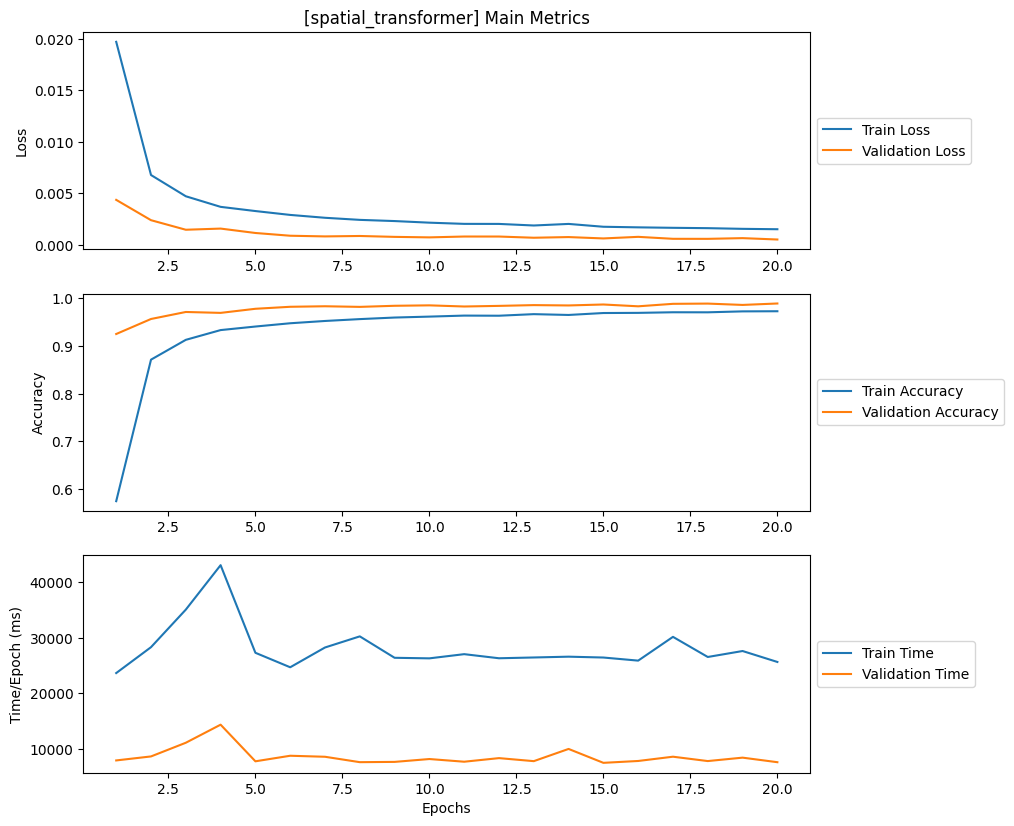

In [14]:
manager.train(epochs=20)

### Visualizing the STN results

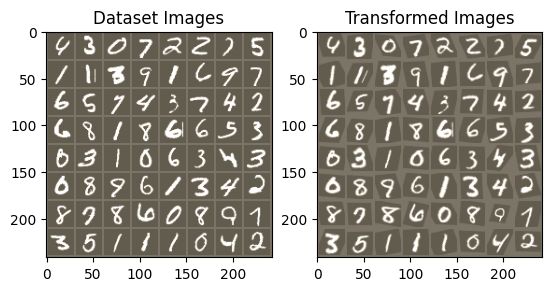

In [15]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.
def visualize_stn():
    model = manager.load_model()

    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()